# An Introduction to BIDMat and Scala

BIDMat is a multi-platform matrix library similar to R, Matlab, Julia or Numpy/Scipy. It takes full advantage of the very powerful Scala Language. Its intended primarily for machine learning, but is has a broad set of operations and datatypes and should be suitable for many other applications. BIDMat has several unique features:

* Built from the ground up with GPU + CPU backends. BIDMat code is implementation independent. 
* GPU memory management uses caching, designed to support iterative algorithms.
* Natural and extensible syntax (thanks to scala). Math operators include +,-,*,/,⊗,∙,∘
* Probably the most complete support for matrix types: dense matrices of float32, double, int and long. Sparse matrices with single or double elements. All are available on CPU or GPU. 
* Highest performance sparse matrix operations on power-law data. 

BIDMat has several other state-of-the-art features:
* Interactivity. Thanks to the Scala language, BIDMat is interactive and scriptable. 
* Massive code base thanks to Java. 
* Easy-to-use Parallelism, thanks to Scala's actor framework and parallel collection classes.  
* Runs on JVM, extremely portable. Runs on Mac, Linux, Windows, Android.
* Cluster-ready, leverages Hadoop, Yarn, Spark etc. 

BIDMat is a library that is loaded by a startup script, and a set of imports that include the default classes and functions. We include them explicitly in this notebook. 

In [6]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,FMat,FND,GMat,GDMat,GIMat,GLMat,GSMat,GSDMat,
               HMat,IMat,Image,LMat,Mat,ND,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.Plotting._

Mat.checkMKL
Mat.checkCUDA
Mat.inline = true
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.99132067,11974557696,12079398912)

These calls check that CPU and GPU native libs loaded correctly, and what GPUs are accessible.
If you have a GPU and CUDA installed, GPUmem will printout the fraction of free memory, the absolute free memory and the total memory for the default GPU. 

## CPU and GPU matrices

BIDMat's matrix types are given in the table below. All are children of the "Mat" parent class, which allows code to be written generically. Many of BIDMach's learning algorithms will run with either single or double precision, dense or sparse input data. 
<table style="width:4in" align="left">
<tr><td/><td colspan="2"><b>CPU Matrices</b></td><td colspan="2"><b>GPU Matrices</b></td></tr>
<tr><td></td><td><b>Dense</b></td><td><b>Sparse</b></td><td><b>Dense</b></td><td><b>Sparse</b></td></tr>
<tr><td><b>Float32</b></td><td>FMat</td><td>SMat</td><td>GMat</td><td>GSMat</td></tr>
<tr><td><b>Float64</b></td><td>DMat</td><td>SDMat</td><td>GDMat</td><td>GSDMat</td></tr>
<tr><td><b>Int32</b></td><td>IMat</td><td></td><td>GIMat</td><td></td></tr>
<tr><td><b>Int64</b></td><td>LMat</td><td></td><td>GLMat</td><td></td></tr>
</table>

In [ ]:
val n = 4096          // "val" designates a constant. n is statically typed (as in Int here), but its type is inferred.
val a = rand(n,n)     // Create an nxn matrix (on the CPU)

In [ ]:
%type a             // Most scientific funtions in BIDMat return single-precision results by default.

CPU matrix operations use Intel MKL acceleration for linear algebra, scientific and statistical functions. BIDMat includes "tic" and "toc" for timing, and "flip" and "flop" for floating point performance. 

In [ ]:
flip; val b = a * a; val gf=gflop
print("The product took %4.2f seconds at %3.0f gflops" format (gf._2, gf._1))
gf

GPU matrices behave very similarly.

In [ ]:
val ga = grand(n,n)            // Another nxn random matrix

In [ ]:
flip; val gb = ga * ga; val gf=gflop
print("The product took %4.2f seconds at %3.0f gflops" format (gf._2, gf._1))
gf

In [ ]:
%type ga

But much of the power of BIDMat is that we dont have to worry about matrix types. Lets explore that with an example.

### SVD (Singular Value Decomposition) on a Budget

Now lets try solving a real problem with this infrastructure: An approximate Singular-Value Decomposition (SVD) or PCA of a matrix M. We'll do this by computing the leading eigenvalues and eigenvectors of M x M^t. The method we use is **subspace iteration** and it generalizes the *power method* for computing the largest-magnitude eigenvalue.

In [ ]:
def SVD(M:Mat, ndims:Int, niter:Int) = {
    var Q = M.zeros(M.nrows, ndims)                 // A block of ndims column vectors
    normrnd(0, 1, Q)                                // randomly initialize the vectors
    Mat.useCache = true                             // Turn matrix caching on
    
    for (i <- 0 until niter) {                      // Perform subspace iteration
        val P = (Q.t * M *^ M).t                    // Compute P = M * M^t * Q efficiently
        QRdecompt(P, Q, null)                       // QR-decomposition of P, saving Q
    }
    Mat.useCache = false                            // Turn caching off after the iteration
    val P = (Q.t * M *^ M).t                        // Compute P again.
    (Q, getdiag(P ^* Q))                            // Return Left singular vectors and singular values
}

Notice that the code above used only the "Mat" matrix type. If you examine the variables V and P in a Scala IDE (Eclipse has one) you will find that they both also have type "Mat". Let's try it with an FMat (CPU single precision, dense matrix).

### Movie Data Example

We load some data from the MovieLens project. 

In [ ]:
val ndims = 32                             // Number of PCA dimension
val niter = 128                            // Number of iterations to do

val S = loadSMat("../data/movielens/train.smat.lz4")(0->10000,0->4000)
val M = full(S)                            // Put in a dense matrix

flip; 
val (svecs, svals) = SVD(M, ndims, niter); // Compute the singular vectors and values
val gf=gflop

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

Let's take a peek at the singular values on a plot

In [ ]:
plot(svals)

In [ ]:
loglog(row(1 to svals.length), svals)

Now lets try it with a GPU, single-precision, dense matrix. 

In [ ]:
val G = GMat(M)                            // Try a dense GPU matrix

flip; 
val (svecs, svals) = SVD(G, ndims, niter); // Compute the singular vectors and values 
val gf=gflop

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

That's not bad, the GPU version was nearly 5x faster. Now lets try a sparse, CPU single-precision matrix. Note that by construction our matrix was only 10% dense anyway.

### Sparse SVD

In [ ]:
flip;                                       // Try a sparse CPU matrix

val (svecs, svals) = SVD(S, ndims, niter);  // Compute the singular vectors and values
val gf=gflop    

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

This next one is important. Dense matrix operations are the bread-and-butter of scientific computing, and now most deep learning. But other machine learning tasks (logistic regression, SVMs, k-Means, topic models etc) most commonly take *sparse* input data like text, URLs, cookies etc. And so performance on sparse matrix operations is critical. 

GPU performance on sparse data, especially *power law* data - which covers most of the case above (the commerically important cases) - has historically been poor. But in fact GPU hardware supports **extremely fast** sparse operations when the kernels are carefully designed. Such kernels are only available in BIDMat right now. NVIDIA's sparse matrix kernels, which have been tuned for sparse scientific data, do not work well on power-law data. 

In any case, let's try BIDMat's GPU sparse matrix type:

In [ ]:
val GS = GSMat(S)                           // Try a sparse GPU matrix

flip;
val (svecs, svals) = SVD(GS, ndims, niter); // Compute the singular vectors and values
val gf=gflop

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

That's a 10x improvement end-to-end, which is similar to the GPU's advantage on dense matrices. This result is certainly not specific to SVD, and is reproduced in most ML algorithms. So GPUs have a key role to play in general machine learning, and its likely that at some point they will assume a central role as they currently enjoy in scientific computing and deep learning. 


### GPU Double Precision

One last performance issue: GPU hardware normally prioritizes single-precision floating point over double-precision, and there is a big gap on dense matrix operations. But calculations on sparse data are memory-limited and this largely masks the difference in arithmetic. Lets try a sparse, double-precision matrix, which will force all the calculations to double precision. 

In [ ]:
val GSD = GSDMat(GS)                             // Try a sparse, double GPU matrix

flip; 
val (svecs, svals) = SVD(GSD, ndims, niter); // Compute the singular vectors and values
val gf=gflop

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

Which is noticebly slower, but still 3x faster than the CPU version running in single precision. 

### Using Cusparse

NVIDIA's cusparse library, which is optimized for scientific data, doesnt perform as well on power-law data. 

In [ ]:
def SVD(M:Mat, ndims:Int, niter:Int) = {
    var Q = M.zeros(M.nrows, ndims)
    normrnd(0, 1, Q)
    Mat.useCache = true     
    for (i <- 0 until niter) {                      // Perform subspace iteration
        val P = M * (M ^* Q)                        // Compute P = M * M^t * Q with cusparse
        QRdecompt(P, Q, null) 
    }
    Mat.useCache = false 
    val P = M * (M ^* Q)                            // Compute P again.
    (Q, getdiag(P ^* Q))                            // Left singular vectors and singular values
}

In [ ]:
                                                   // Try sparse GPU matrix
flip; 
val (svecs, svals) = SVD(GS, ndims, niter); 
val gf=gflop

print("The calculation took %4.2f seconds at %2.1f gflops" format (gf._2, gf._1))
svals.t

## Unicode Math Operators and Functions

As well as the standard operators +,-,*,/, BIDMat includes several other important operators with their standard unicode representation. They have an ASCII alias in case unicode input is difficult. Here they are:

<pre>
Unicode operator    ASCII alias    Operation
================    ===========    =========
       ∘                *@         Element-wise (Hadamard) product
       ∙                dot        Column-wise dot product
       ∙→              dotr        Row-wise dot product
       ⊗               kron        Kronecker (Cartesian) product
</pre>

In [ ]:
val a = ones(4,1) * row(1->5)

In [ ]:
val b = col(1->5) * ones(1,4)

Hadamard (element-wise) multiply

In [ ]:
b ∘ a

Dot product, by default along columns

In [ ]:
b ∙ a 

Dot product along rows

In [ ]:
b ∙→ a

Kronecker product

In [ ]:
b ⊗ a

As well as operators, functions in BIDMach can use unicode characters. e.g. 

In [ ]:
val ii = row(1->10)

In [ ]:
ii on Γ(ii)                            // Stack this row on the results of a Gamma function applied to it

## Transposed Multiplies

Matrix multiply is the most expensive step in many calculations, and often involves transposed matrices. To speed up those calcualtions, we expose two operators that combine the transpose and multiply operations:

<pre>
^&ast;  - transpose the first argument, so a ^&ast; b is equivalent to a.t &ast; b
&ast;^  - transpose the second argument, so a &ast;^ b is equivalent to a &ast; b.t
</pre>
these operators are implemented natively, i.e. they do not actually perform transposes, but implement the effective calculation. This is particulary important for sparse matrices since transpose would involve an index sort. 

In [ ]:
a ^* b

In [ ]:
a.t * b

In [ ]:
a *^ b

In [ ]:
a * b.t

# Highlights of the Scala Language

Scala is a remarkable language. It is an object-oriented language with similar semantics to Java which it effectively extends. But it also has a particular clean functional syntax for anonymous functions and closures. 

It has a REPL (Read-Eval-Print-Loop) like Python, and can be used interactively or it can run scripts in or outside an interactive session. 

Like Python, types are determined by assignments, but they are static rather than dynamic. So the language has the economy of Python, but the type-safety of a static language. 

Scala includes a tuple type for multiple-value returns, and on-the-fly data structuring. 

Finally it has outstanding support for concurrency with parallel classes and an **actor** system called Akka. 

## Performance

First we examine the performance of Scala as a scientific language. Let's implement an example that has been widely used to illustrate the performance of the Julia language. Its a random walk, i.e. a 1D array with random steps from one element to the next. 

In [ ]:
import java.util.Random
val random = new Random()

def rwalk(m:FMat) = {
    val n = m.length
    m(0) = random.nextFloat
    var i = 1
    while (i < n) {
        m(i) = m(i-1) + random.nextFloat - 0.5f
        i += 1
    }
}

In [ ]:
val n = 100000000
val a = zeros(n, 1)
tic; val x = rwalk(a); val t=toc
print("computed %2.1f million steps per second in %2.1f seconds" format (n/t/1e6f, t))

If we try the same calculation in the Julia language (a new language designed for scientific computing) and in Python we find that:

<table style="width:4in" align="left">
<tr><td></td><td><b>Scala</b></td><td><b>Julia</b></td><td><b>Python</b></td></tr>
<tr><td><b>with rand</b></td><td>1.0s</td><td>0.43s</td><td>147s</td></tr>
<tr><td><b>without rand</b></td><td>0.1s</td><td>0.26s</td><td>100s</td></tr>
</table>


### Vectorized Operations

But does this matter? A random walk can be computed efficiently with vector operations: vector random numbers and a cumulative sum. And in general most ML algorithms can be implemented with vector and matrix operations efficiently. Let's try in BIDMat:

In [ ]:
tic; rand(a); val b=cumsum(a-0.5f); val t=toc
print("computed %2.1f million steps per second in %2.1f seconds" format (n/t/1e6f, t))

Which is better, due to the faster random number generation in the vectorized rand function. But More interesting is the GPU running time:

In [ ]:
val ga = GMat(a)
tic; rand(ga); val gb=cumsum(ga-0.5f); val t=toc
print("computed %2.1f million steps per second in %2.1f seconds" format (n/t/1e6f, t))

If we run similar operators in Julia and Python we find:

<table style="width:5in" align="left">
<tr><td></td><td><b>BIDMach(CPU)</b></td><td><b>BIDMach(GPU)</b></td><td><b>Julia</b></td><td><b>Python</b></td></tr>
<tr><td><b>with rand</b></td><td>0.6s</td><td>0.1s</td><td>0.44s</td><td>1.4s</td></tr>
<tr><td><b>without rand</b></td><td>0.3s</td><td>0.05s</td><td>0.26s</td><td>0.5s</td></tr>
</table>

Vectorized operators even the playing field, and bring Python up to speed compared to the other systems. On the other hand, GPU hardware maintains a near-order-of-magnitude advantage for vector operations. 

## Tapping the Java Universe

In [15]:
<img style="width:4in" alt="NGC 4414 (NASA-med).jpg" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/NGC_4414_%28NASA-med%29.jpg/1200px-NGC_4414_%28NASA-med%29.jpg"/>

<img style="width:4in" alt="NGC 4414 (NASA-med).jpg" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/NGC_4414_%28NASA-med%29.jpg/1200px-NGC_4414_%28NASA-med%29.jpg"/>

Almost every piece of Java code can be used in Scala. And therefore any piece of Java code can be used interactively. 

There's very little work to do. You find a package and add it to your dependencies and then import as you would in Java.

In [ ]:
import org.apache.commons.math3.stat.inference.TestUtils._

Apache Commons Math includes a Statistics package with many useful functions and tests. Lets create two arrays of random data and compare them. 

In [ ]:
val x = normrnd(0,1,1,40)
val y = normrnd(0,1,1,40) + 0.5

BIDMat has enriched matrix types like FMat, SMat etc, while Apache Commons Math expects Java Arrays of Double precision floats. To get these, we can convert FMat to DMat (double) and extra the data field which contains the matrices data. 

In [ ]:
val dx = DMat(a)
val dy = DMat(b)
tTest(da.data, db.data)

But rather than doing this conversion every time we want to use some BIDMat matrices, we can instruct Scala to do the work for us. We do this with an **implicit conversion** from FMat to Array[Double]. Simply defining this function will case a coercion whenever we supply an FMat argument to a function that expects Array[Double].

In [ ]:
implicit def fMatToDarray(a:FMat):Array[Double] = DMat(a).data

And magically we can perform t-Tests on BIDMat matrices as though they had known each other all along. 

In [ ]:
tTest(x, y)

In [2]:
import org.apache.commons.math3.distribution._

val betadist = new BetaDistribution(2,5)

org.apache.commons.math3.distribution.BetaDistribution@4d1d2921

In [12]:
val n = 100000
val x = new DMat(1, n, (0 until n).map(x => betadist.sample).toArray); null

null

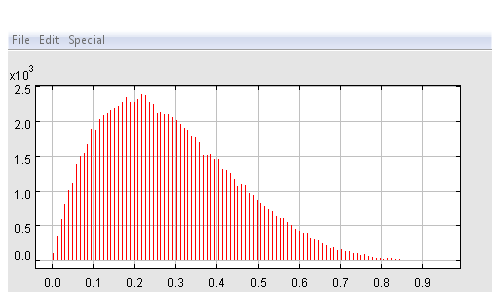

In [13]:
hist(x, 100)

## Deconstruction

In [16]:
<image src="https://sketchesfromthealbum.files.wordpress.com/2015/01/jacquesderrida.jpg" style="width:4in"/>

<image src="https://sketchesfromthealbum.files.wordpress.com/2015/01/jacquesderrida.jpg" style="width:4in"/>

Let's make a raw Java Array of float integers.

In [ ]:
val i = row(0->10).data

First of all, Scala supports Tuple types for ad-hoc data structuring. 

In [ ]:
val j = i.map(x => (x, x*x))

We can also **deconstruct** tuples using Scala Pattern matching:

In [ ]:
j.map{case (x,y) => (y,x)}

And reduce operations can use deconstruction as well:

In [ ]:
val k = j.reduce((ab,cd) => {val (a,b) = ab; val (c,d) = cd; (a+c, b+d)})